## Estimating causal effect of moisture on NPP

In this notebook, we use FluxNet data to test the NPP/NEE-moisture sensitivity. 

We focus on the sites in US, AU, Mongolian and EU. 

We use NPP as Y, and first use precipitation as X, and then soil moisture as X. 

Is the confounder variable temporal or spatial? Two assumptions are both testable. 

[//]: # "the confounder could be spatial factor, such as site, local climatology, or PFTs. "

Reference: 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3479688/

https://arxiv.org/pdf/2005.08639.pdf


In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns


#### Load data

Fluxnet annul data is used. See this [link](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/) for more information.



In [9]:
# this should be read only, use Jianing's data
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'
site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)
meta_file = pd.read_csv(path_ro+'/FLUXNET_YY_metadata.csv')  
meta_file['length'] = meta_file['end_year'] - meta_file['start_year'] + 1 
meta_file = meta_file.loc[meta_file.length >= 10]
print(len(meta_file))
# meta_file.SITE_ID
# site

69


In [5]:
# Use US-Ha1 and US-Var to test 
## XX stands for percentiles, CUT stands for Constant Ustar Threshold and VUT stands for Variable Ustar Threshold 

sitename = 'US-Ha1'
GPP_flag = -9999
file = os.listdir(path_ro+'/'+sitename)
print('number of files in this directory is: ', len(file))
filename = file[0]
data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)

# for i in data.columns:
#     print(i)

number of files in this directory is:  1


data length in years from this site:  22


Text(0, 0.5, 'carbon flux')

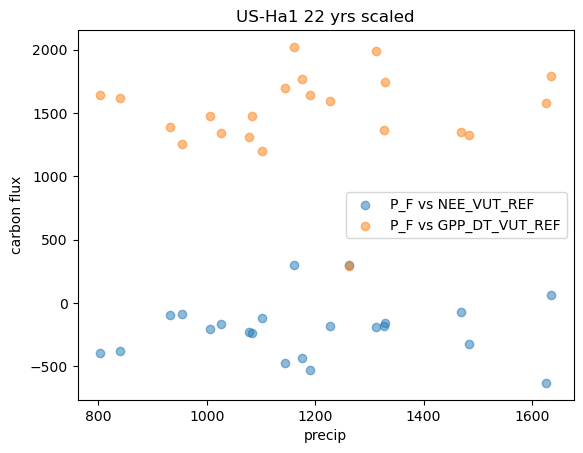

In [36]:
data = data[['GPP_NT_VUT_REF', 'GPP_DT_VUT_REF','NEE_VUT_REF', 
             # 'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'NEE_CUT_REF',
             # 'NEE_CUT_USTAR50', 'NEE_VUT_USTAR50',
             # 'NEE_CUT_MEAN', 'NEE_VUT_MEAN',
             'P_F',]] #  'P_ERA', 

# there is no soil water content in the data 'SWC_F_MDS_#'

# data = (data - data.mean())/data.std()
data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
print('data length in years from this site: ', len(data))

### plt.scatter(data.P_F, data.NEE_CUT_REF, label = 'P_F NEE CUT REF', alpha = 0.5)
plt.scatter(data.P_F, data.NEE_VUT_REF, label = 'P_F vs NEE_VUT_REF', alpha = 0.5)
plt.scatter(data.P_F, data.GPP_DT_VUT_REF, label = 'P_F vs GPP_DT_VUT_REF', alpha = 0.5)

### plt.scatter(data.P_ERA, data.NEE_CUT_REF, label = 'P_ERA NEE CUT REF', alpha = 0.5)
### plt.scatter(data.P_ERA, data.NEE_VUT_REF, label = 'P_ERA NEE VUT REF', alpha = 0.5)
plt.legend()
plt.title(sitename+' '+str(len(data))+' yrs scaled')
plt.xlabel('precip')
plt.ylabel('carbon flux')


### Merge / append all the sites data together

Different sites have different data length/sample number. Select the sites with >=10 years of data.

In [29]:
min_yrs = 10
GPP_flag = -9999
varname = ['P_F', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'NEE_VUT_REF']
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'

site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)

def merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag):
    # output data_allsites: the dataframe to contain all sites' info
    # input site: a list containing all sites' names
    # input min_yrs: minimum sample number (yr) required for each site to be include
    # input GPP_flag: use to filter missing/weird data
    
    # global data_allsites
    data_allsites = pd.DataFrame(data = None, index = None, columns = varname)
    data_allsites.index.name = 'site'
    
    for sitename in site:
        # print('processing site: ', sitename)
        file = os.listdir(path_ro+'/'+sitename)
        if len(file) > 1:
            print('number of files in this directory is: ', len(file))
        filename = file[0]
        data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)
        data = data[varname]
        data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
        # print('data length in years from this site: ', len(data))
        
        if len(data) >= min_yrs:
            data['site'] = sitename
            data = data.set_index('site')
            # data_allsites = data_allsites.append(data, ignore_index = False) 
            data_allsites = pd.concat([data_allsites, data])
            
    return data_allsites
        
data_allsites = merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag)
site_new = data_allsites.index.unique()

data_allsites

,P_F,GPP_NT_VUT_REF,GPP_DT_VUT_REF,NEE_VUT_REF
site,,,,
DE-Geb,423.278,1188.070,1260.300,-198.7360
DE-Geb,674.086,896.108,927.332,-36.1059
DE-Geb,388.100,990.353,1024.750,-301.6900
DE-Geb,506.600,1289.000,1312.030,-233.3910
DE-Geb,521.900,1272.410,1268.040,-90.1472
...,...,...,...,...
CH-Fru,1771.200,1981.580,1755.200,-234.7880
CH-Fru,696.180,2312.110,1998.360,-318.9610
CH-Fru,1159.938,1995.700,2036.320,-205.0280


### Spatial confounder assumption

Use site as the the hidden confounder H.

Recall the ground-truth formula for $Y$ if using OLS to estimate $Y$ from $X$:

$$
\begin{align}
f_{AVE}(X \rightarrow Y)(x) = \frac{1}{n} \sum_{i=1}^{n} (1 \ \  x) \hat{\beta}_{OLS}(X^m_i,Y^m_i) \\
\end{align}
$$



The estimated causal coefficients: a = -274.62, b= -0.05


Text(0.5, 1.0, 'OLS fit slope and intercept at all sites')

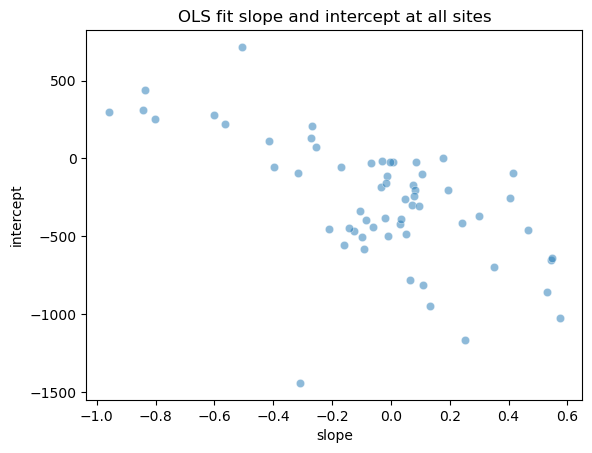

In [78]:
# estimated coefficients when we decorrelate spatial dependency (ie. compute coefficient at each location)
xname = 'P_F'
yname = 'NEE_VUT_REF'

# this is to compute the linear regression for each site
def bhat(data_allsites, xname, yname):
    # N: site number
    results = list()
    
    site_new = data_allsites.index.unique()
    N = len(site_new) # number of sites
    
    for s, sname in enumerate(site_new):
        Xs = data_allsites.loc[sname][xname].values
        Ys = data_allsites.loc[sname][yname].values
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])
        
    return np.array(results)
    
bhat_data = bhat(data_allsites, xname, yname)
b_causal_data = np.mean(bhat_data, axis=0)
print(f"The estimated causal coefficients: a = {b_causal_data[0].item():.2f}, b= {b_causal_data[1].item():.2f}")

sns.scatterplot(data=linedata, x = 'slope', y = 'intercept', alpha=.5, linewidth=.5,)
plt.title('OLS fit slope and intercept at all sites')

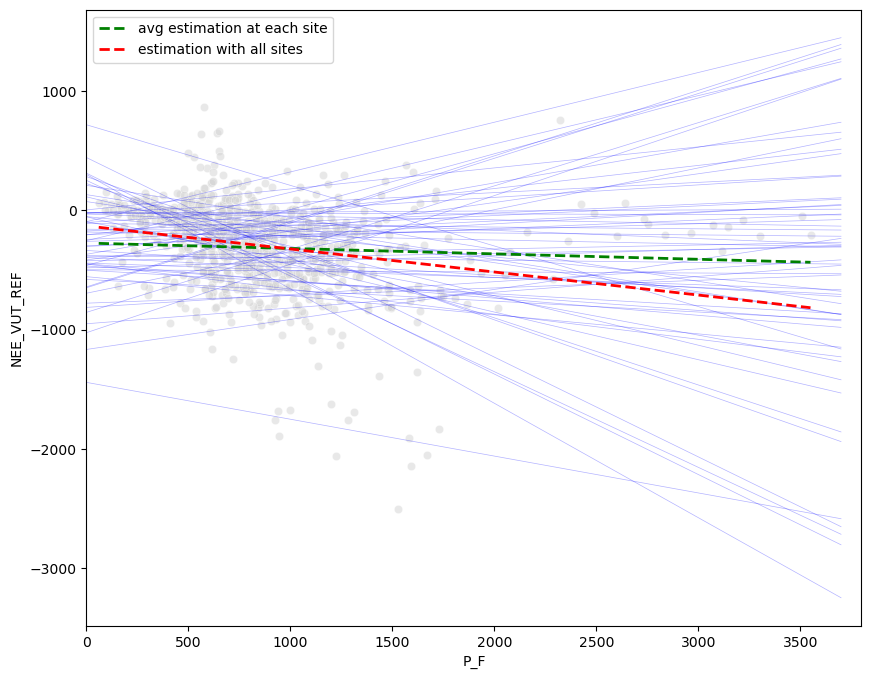

In [85]:
## red: linear regression using all data
## thin blue: linear regressions within each site/location
## green: estimate of the avg causal effect

X = data_allsites[xname].values.ravel()
Y = data_allsites[yname].values.ravel()
model = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
a = model.intercept_
b = model.coef_[0]
x_increments = np.arange(0,3800,100)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=data_allsites[list([xname,yname])], x=xname, y=yname, alpha=.5, color='lightgrey', ax=ax)

for i in range(bhat_data.shape[0]):
    bhat_d = bhat_data[i]
    sns.lineplot(x = x_increments, y = bhat_d[0] + x_increments * bhat_d[1], color='blue', linewidth=0.5, alpha=0.3, ax=ax)

sns.lineplot(x = X, y = b_causal_data[0] + b_causal_data[1]*X, color='green', linewidth=2, linestyle='--', label='avg estimation at each site', ax=ax)
sns.lineplot(x = X, y = a + b*X, color='red', linewidth=2, linestyle='--', label='estimation with all sites', ax=ax)

ax.set_xlabel(xname)
ax.set_xlim([0, 3800])
ax.set_ylabel(yname)
plt.show()

### Temporal confounder assumption

Use ENSO index, such as Nino3.4 as the hidden confounder H.

### Ecological confounder assumption
Use PFT as the hidden confounder H.